# Identifying Ineffective operations

In [4]:
import json
import os
import pandas as pd

from plotly.offline import init_notebook_mode
from sqlalchemy import create_engine

from query_flow.parsers.postgres_parser import PostgresParser
from query_flow.vizualizers.query_vizualizer import QueryVizualizer

# The following lines only needed for rendering in github
# and require conda install -c plotly plotly-orca psutil
import plotly.io as pio
pio.renderers.default = "png"

**Problems related to ineffective operations are common and finding them tends to be nearly impossible with today ‘s tooling.** These kinds of flaws are related to performance, and although it won’t make your query wrong, it has negative effects on your DBMS’s cost, customers, and internal DBMS users. 

Using QueryFlow, we can visualize the cardinality (actual_rows) of the query’s sub-expressions and find ineffective operations.  Ineffective operations are operations that should change the granularity of its direct ancestor but don’t, for example, a UNIQUE clause that filters nothing. This problem can be caused due to either WHERE, JOIN, UNION, HAVING, or UNIQUE clauses. 

To show an example of an ineffective operation, we introduce the following question, “list all comedy movies and all action movies”, this question is equivalent to the SQL query in the next cell.But to make it work without generating the database locally we will use a mock.

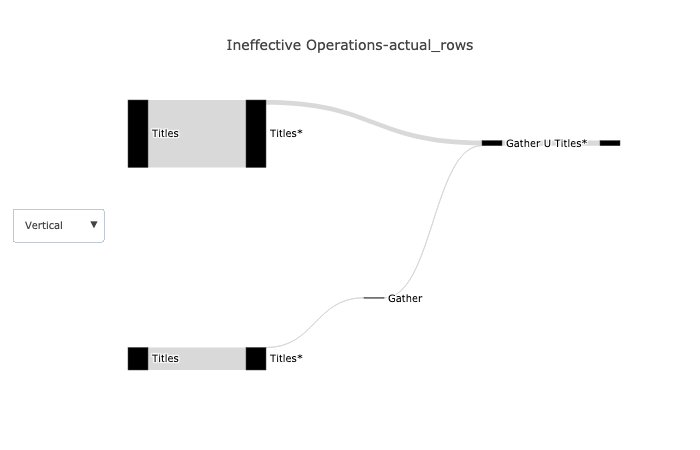

In [5]:
con_str = 'postgresql:///etrabelsi_thesis'
parser = PostgresParser()                                 
query_renderer = QueryVizualizer(parser)
query = """
SELECT titles.title_id
FROM titles
WHERE genres = 'Comedy' 

UNION 
SELECT titles.title_id
FROM titles
WHERE genres = 'Action' 
"""

                                 
if os.environ.get("NOT_MOCK"):
    flow_df = query_renderer.get_flow_df(query, con_str)    
else:
    mock_path = f'../tests/parsers/data/postgres/parse/ineffective_operation/execution_plan.json'
    flow_df = parser.parse([json.loads(open(mock_path).read())])

query_renderer.vizualize(flow_df, title="Ineffective Operations", metrics=["actual_rows"], open_=False)

Using the Sankey visualization, we can see that the Unique sub-expression (part of UNION) is redundant (it filters nothing) as it is marked in orange or by hovering both operations and looking at the number of rows.  This affects the execution time of the query, and the query took 9.3 seconds. The execution time is taken out of the last node’s “Total time” (The time it took the database to run this node and all its ancestors).


In PostgreSQL, the difference between UNION ALL and UNION is that the first only appends two relations and the second removes duplicate entries after the append. Since both relations are disjoint, there is no need for removing duplications after the append. This does not affect the query correctness but improves the query performance as Unique is a very expensive operation.